# Biometric Enhanced Login Detection Pipeline (Rule + ML Hybrid)

This notebook serves as the **main driver** for the Biometric Login Detection System. It reproduces the full detection pipeline combining:
- **Synthetic login metadata** (simulated user behavior)
- **Keystroke dynamics** from the KeyRecs dataset
- **Rule-based detection**, using both login metadata and biometric patterns (variance, timing)
- **Machine learning classifier**, trained solely on real keystroke data
- A **hybrid pipeline** that flags if *either* the rule logic or the ML model triggers detection


### Setup and Imports

This section initializes the notebook environment and imports all necessary libraries for simulation, modeling, and evaluation. 

Note: If running in Google Colab, uncomment the installation command at the top.

In [1]:
# If running in Colab, install required packages
# !pip install seaborn matplotlib scikit-learn pandas joblib

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import joblib
import ast
import os
import uuid
import random
from datetime import datetime, timedelta
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix


### Load and Process Keystroke Data

This section loads the KeyRecs dataset (`fixed-text.csv`) and splits it into two user groups:
- **Known users** (participants p001–p010): labeled as normal (0)
- **Unknown users**: labeled as anomalous (1)

Only timing-based keystroke features are retained. The processed vectors, along with labels, are saved for downstream use by the ML model and login simulation.


In [2]:
# Load KeyRecs CSV
df = pd.read_csv("data/fixed-text.csv")

# Define known users (normal)
known_ids = [f'p{str(i).zfill(3)}' for i in range(1, 11)] 
known = df[df['participant'].isin(known_ids)].copy()
unknown = df[~df['participant'].isin(known_ids)].copy()

# Assign labels
known['label'] = 0
unknown['label'] = 1
combined = pd.concat([known, unknown])

# Extract features
feature_cols = combined.columns[4:-1]
X = combined[feature_cols].copy()
X['label'] = combined['label'].values

os.makedirs("keystroke_ml/processed", exist_ok=True)
X.to_csv("keystroke_ml/processed/keystroke_vectors.csv", index=False)


### Train Keystroke-Based ML Classifer

Trains a Random Forest classifier using the labeled keystroke vectors generated earlier:
- **Training set**: 80% stratified split
- **Model**: RandomForestClassified with class balancing

After training, the model is evaluated on the test set using precision, recall, F1, and confusion matrix. Results are saved for downstream hybrid detection evaluation.

In [3]:
df = pd.read_csv("keystroke_ml/processed/keystroke_vectors.csv")
X = df.drop(columns=["label"])
y = df["label"]

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

clf = RandomForestClassifier(n_estimators=100, class_weight="balanced", random_state=42)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

print("Classification Report:")
print(classification_report(y_test, y_pred, digits=4))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

os.makedirs("results", exist_ok=True)
pd.DataFrame({"true_label": y_test, "prediction": y_pred}).to_csv("results/keystroke_ml_predictions.csv", index=False)
os.makedirs("models", exist_ok=True)
joblib.dump(clf, "models/keystroke_rf_model.joblib")


Classification Report:
              precision    recall  f1-score   support

           0     1.0000    0.4200    0.5915       400
           1     0.9387    1.0000    0.9684      3555

    accuracy                         0.9413      3955
   macro avg     0.9694    0.7100    0.7800      3955
weighted avg     0.9449    0.9413    0.9303      3955

Confusion Matrix:
[[ 168  232]
 [   0 3555]]


['models/keystroke_rf_model.joblib']

### Simulate Login Attempts (Synthetic Data Generation)

This section generates a synthetic dataset of login attempts that mimics real-world enterprise login behavior. The simulation includes:

- **Normal users**: 250 users with 1-3 login attempts per session and varying outcomes.
- **Brute-force attackers**: 50 attackers with 10-50 rapid login attempts and varied usernames.
- **Evasive attackers**: 50 attackers using username variation and human-like delays to avoid detection.

Each attempt is tagged with a timestamp, result (success/failure), username, user type, time delay, and a keystroke vector.

In [4]:
# generate_logins.py
import random
import pandas as pd
from datetime import datetime, timedelta
import uuid
from typing import List, Dict

# Constants for simulation configuration

NUM_NORMAL_USERS = 250
NUM_BRUTE_FORCE_ATTACKERS = 50
NUM_EVASIVE_ATTACKERS = 50

# Load keystroke data
KEYSTROKE_PATH = "keystroke_ml/processed/keystroke_vectors.csv"
keystroke_df = pd.read_csv(KEYSTROKE_PATH)

# Separate known and unknown vectors
known_vectors = keystroke_df[keystroke_df["label"] == 0].drop(columns = ["label"]).values.tolist()
unknown_vectors = keystroke_df[keystroke_df["label"] == 1].drop(columns = ["label"]).values.tolist()

# Helper to generate usernames
def generate_username(prefix: str, index: int) -> str:
    return f"{prefix}_user_{index}"

# Simulates a sequence of login attempts for one user or attacker session
def simulate_login_attempts(user_type: str, user_id: str, outcomes: List[str],
                            min_delay: int, max_delay: int, 
                            varied_usernames: bool = False, 
                            stop_on_success: bool = False,
                            keystroke_vector: List[float] = None):
    logs = []
    last_time = datetime.now()
    session_id = str(uuid.uuid4())

    for attempt, result in enumerate(outcomes):
        delay_secs = random.randint(min_delay, max_delay)
        delay = timedelta(seconds = delay_secs)

        current_time = last_time + delay
        last_time = current_time

        # Determine username
        username = (
            generate_username("normal", random.randint(0, NUM_NORMAL_USERS- 1))
            if varied_usernames
            else generate_username(user_type, user_id)
        )
        

        logs.append({
            "timestamp": current_time.isoformat(),
            "username": username,
            "result": result,
            "user_type": user_type,
            "session_id": session_id,
            "attempt_number": attempt + 1,
            "time_since_last": 0 if attempt == 0 else delay.total_seconds(),
            "keystroke_vector": keystroke_vector,
            "label": 0 if user_type == "normal" else 1
        })

        if result == "success" and stop_on_success:
            break

    return logs

# Runs the full simulation and aggregates all logs
def generate_login_simulation() -> pd.DataFrame:
    all_logs = []

    # Normal users: mostly 1-3 login attempts per session
    for i in range(NUM_NORMAL_USERS):
        num_attempts = random.choices([1, 2, 3], weights=[0.7, 0.25, 0.05])[0]
        session_type = random.choices(
            ["one_try", "two_try", "three_try", "give_up"],
            weights = [0.7, 0.2, 0.05, 0.05]
        )[0]
        vector = random.choice(known_vectors)
        if session_type == "give_up":
            outcomes = ["failure" , "failure" ,"failure"]
        elif session_type == "three_try":
            outcomes = ["failure" , "failure" ,"success"]
        elif session_type == "two_try":
            outcomes = ["failure" ,"success"]
        else:
            outcomes = ["success"]

        logs = simulate_login_attempts(
            user_type = "normal",
            user_id = str(i),
            outcomes = outcomes,
            min_delay=3,
            max_delay=5,
            keystroke_vector = vector
        )
        all_logs.extend(logs)
    
    # Brute-force attackers: 10-50 rapid fire attempts
    for i in range(NUM_BRUTE_FORCE_ATTACKERS):
        num_attempts = random.randint(10, 50)
        outcomes = ["success" if random.random() < 0.01 else "failure" for _ in range(num_attempts)]
        vector = random.choice(unknown_vectors)
        logs = simulate_login_attempts(
            user_type = "brute_force",
            user_id = str(i),
            outcomes = outcomes,
            min_delay= 0,
            max_delay= 1,
            varied_usernames = True,
            stop_on_success = True,
            keystroke_vector = vector
        )
        all_logs.extend(logs)

    # Evasive attackers: 5-20 moderate-paced attempts with username variation
    for i in range(NUM_EVASIVE_ATTACKERS):
        num_attempts = random.randint(5, 20)
        outcomes = ["success" if random.random() < 0.03 else "failure" for _ in range(num_attempts)]
        vector = random.choice(unknown_vectors)
        logs = simulate_login_attempts(
            user_type = "evasive",
            user_id = str(i),
            outcomes = outcomes,
            min_delay = 3,
            max_delay = 15,
            varied_usernames = True,
            stop_on_success = True,
            keystroke_vector = vector
        )
        all_logs.extend(logs)
    
    return pd.DataFrame(all_logs)

# Run the simulation and export to CSV
if __name__ == "__main__":
    login_df = generate_login_simulation()
    login_df["keystroke_vector"] = login_df["keystroke_vector"].apply(lambda x: str(x))
    login_df = login_df.sort_values("timestamp").reset_index(drop = True)
    login_df.to_csv("data/login_simulation.csv", index = False)
    print("Simulation complete. File saved as 'login_simulation.csv'")

Simulation complete. File saved as 'login_simulation.csv'


### Export Simulated Logins

This step finalizes the simulated login dataset:

- **`generate_login_simulation()`** is called to create the synthetic login data.
- Keystroke vectors are serialized as strings for CSV compatibility

In [5]:
df_sim = generate_login_simulation()
df_sim["keystroke_vector"] = df_sim["keystroke_vector"].apply(str)
os.makedirs("data", exist_ok=True)
df_sim.to_csv("data/login_simulation.csv", index=False)


### Rule-Based Detection Module

This section evaluates simulated login sessions using handcrafted detection rules grounded in common security heuristics:

- **Brute Force Detection:** Flags rapid login bursts with many failed attempts.
- **Evasive Attack Detection:** Detects spread-out attempts with varied usernames and low success.
- **Typing Biometrics:** Incorporates keystroke vector statistics to catch anomalies like:
  - **High Variance:** Suggests inconsistent or unnatural typing.
  - **Unrealistically Fast Input:** May indicate automated tools.

In [6]:
# rule_based_detector.py
import pandas as pd
from collections import defaultdict
import os
import ast

# Config: thresholds for rules and used for tuning
BRUTE_FORCE_ATTEMPT_THRESHOLD = 10
BRUTE_FORCE_TIME_THRESHOLD = 3 # seconds
EVASIVE_DURATION_THRESHOLD = 60 # total time > 1 minutes
EVASIVE_USERNAME_THRESHOLD = 3 # at least 3 distinct usernames in session
LOW_SUCCESS_RATE = 0.1
HIGH_VARIANCE_THRESOLD = 0.45
LOW_TYPING_TIME_THRESHOLD = 0.08

# Load simulated login data
df = pd.read_csv("data/login_simulation.csv")

# Parse stringified vectors into real lists
df["keystroke_vector"] = df["keystroke_vector"].apply(ast.literal_eval)

# Group by session
sessions = df.groupby("session_id")

# Storage for rule-based predictions
results = []

for session_id, group in sessions:
    # Extract All keystroke vectors in the session
    vectors = group["keystroke_vector"].tolist()
    flat_vector = [v for session in vectors for v in session]
    
    if flat_vector:
        avg_delay = sum(flat_vector) / len(flat_vector)
        std_delay = pd.Series(flat_vector).std()
    else:
        avg_delay = 0
        std_delay = 0
    
    usernames = group['username'].nunique()
    attempts = len(group)
    total_time = group['time_since_last'].sum()
    success_count = (group['result'] == "success").sum()
    failure_count = (group['result'] == "failure").sum()
    success_rate = success_count / attempts if attempts else 0
    user_type = group['user_type'].iloc[0] # for sanity check or eval

    flag = 0
    reason = "normal"

    # Rule 1: Brute force - many fast attempts
    if attempts >= BRUTE_FORCE_ATTEMPT_THRESHOLD and total_time <= BRUTE_FORCE_TIME_THRESHOLD:
        flag = 1
        reason = "brute_force_pattern"

    # Rule 2: Evasive - low succuss, spread out, multiple usernames
    elif success_rate < LOW_SUCCESS_RATE and attempts >= 5:
        flag = 1
        reason = "evasive_pattern"

    # Rule 3: High variance in typing
    if std_delay > HIGH_VARIANCE_THRESOLD:
        flag = 1
        reason = "high_typing_variance"
    
    # Rule 4: Unrealistically fast typing
    elif avg_delay < LOW_SUCCESS_RATE:
        flag = 1
        reason = "unrealistic_typing_speed"

    results.append({
        "session_id": session_id,
        "username_sample": group['username'].iloc[0],
        "num_attempts": attempts,
        "total_time": total_time,
        "success_rate": round(success_rate, 2),
        "distince_usernames": usernames,
        "rule_prediction": flag,
        "rule_reason": reason,
        "avg_keystroke_delay": round(avg_delay, 4),
        "std_keystroke_delay": round(std_delay, 4),
        "true_label": group['label'].iloc[0]
    })

# Save rule-based results
out_df = pd.DataFrame(results)
os.makedirs("results", exist_ok = True)
out_df.to_csv("results/rule_based_flags.csv", index = False)
print("Rule-based detection complete. Output saved to 'results/rule_based_flags.csv'")

Rule-based detection complete. Output saved to 'results/rule_based_flags.csv'


### Hybrid Detection Pipeline (Rule + ML)

This section runs the **full detection pipeline**, integrating:

- **Rule-Based Logic:** Re-applies handcrafted detection rules (e.g., brute force, evasive, biometric anomalies).
- **ML Classifier:** Uses the trained Random Forest model on keystroke vectors to classify each session.

The **final decision** uses a simple **OR logic**:
- A session is flagged if **either** the rule-based logic or ML predicts it as malicious.
- Results include both individual module predictions and the combined flag/reason.

WARNING: Keep thresholds in rule_based_detector.py and pipeline_detector.py in sync manually.

In [7]:
# pipeline_detector.py
import pandas as pd
import ast
import joblib
import os
from sklearn.ensemble import RandomForestClassifier

# Load login sessions
df = pd.read_csv("data/login_simulation.csv")
df["keystroke_vector"] = df["keystroke_vector"].apply(ast.literal_eval)

# Load trained ML model
clf = joblib.load("models/keystroke_rf_model.joblib")

# Group by session
grouped = df.groupby("session_id")

results = []

for session_id, group in grouped:
    # Rule-Based Logic
    # WARNING: Must reuse current thresholds as rule_based_detector.py
    flag_rule = 0
    reason = "normal"

    attempts = len(group)
    total_time = group["time_since_last"].sum()
    usernames = group["username"].nunique()
    success_rate = (group["result"] == "success").sum() / attempts if attempts else 0

    vector = group["keystroke_vector"].iloc[0]

    avg_delay = sum(vector) / len(vector) if vector else 0
    std_delay = pd.Series(vector).std() if vector else 0

    # Rule Checks
    if attempts >= 10 and total_time <= 3:
        flag_rule = 1
        reason = "brute_force_pattern"
    elif success_rate < 0.1 and attempts >= 5 and usernames >= 3 and total_time > 60:
        flag_rule = 1
        reason = "evasive_pattern"
    elif std_delay > 0.45:
        flag_rule = 1
        reason = "high_typing_variance"
    elif avg_delay < 0.08:
        flag_rule = 1
        reason = "unrealistic_typing_speed"
    
    # ML Prediction
    feature_names = pd.read_csv("keystroke_ml/processed/keystroke_vectors.csv", nrows = 1).drop(columns = ["label"]).columns.tolist()
    ml_input = pd.DataFrame([vector], columns = feature_names)
    pred_ml = clf.predict(ml_input)[0]

    # Final
    final_flag = 1 if flag_rule == 1 or pred_ml == 1 else 0
    final_reason = "both" if flag_rule == 1 and pred_ml == 1 else ("rule" if flag_rule else "ml" if pred_ml else "none")

    results.append({
        "session_id": session_id,
        "rule_prediction": flag_rule,
        "ml_prediction": pred_ml,
        "final_flag": final_flag,
        "final_reason": final_reason,
        "success_rate": round(success_rate, 3),
        "avg_delay": round(avg_delay, 4),
        "std_delay": round(std_delay, 4),
        "true_label": group["label"].iloc[0]
    })

# Save
os.makedirs("results", exist_ok = True)
pd.DataFrame(results).to_csv("results/pipeline_flags.csv", index = False)
print("Pipeline detection complete. Input saved to results/pipeline_flags.csv")

Pipeline detection complete. Input saved to results/pipeline_flags.csv


### Final Evaluation and Metrics Comparison

This section compares the performance of all three detection approaches:

- **Rule-Based:** Flags sessions using handcrafted rules on login metadata and biometric signals.
- **ML-Based:** Predicts based solely on keystroke vectors using the trained Random Forest classifier.
- **Hybrid (Pipeline):** Combines both approaches using OR logic — a session is flagged if either method does.

Each model’s output is evaluated using:
- **Precision, Recall, F1 Score** (via `classification_report`)
- **Confusion Matrix** visualization


=== Rule-Based ===


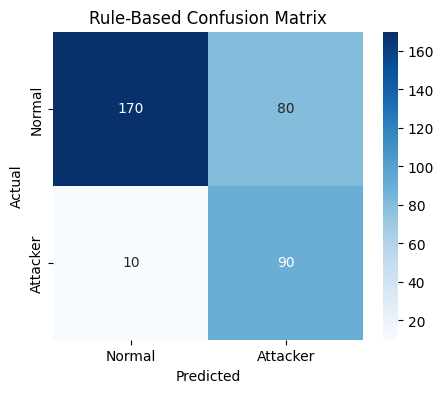


=== ML-Based ===


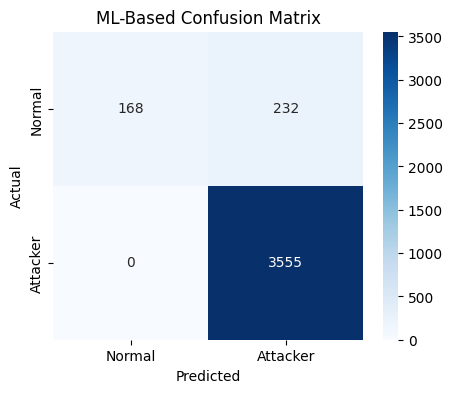


=== Hybrid ===


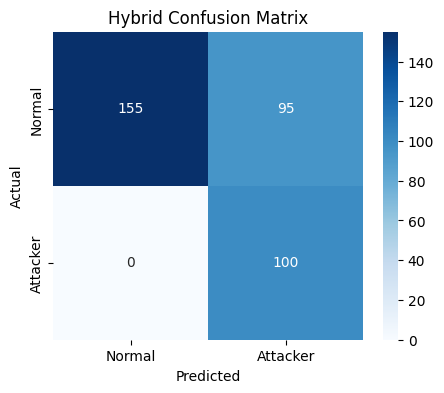

In [8]:
def evaluate_and_save_metrics(df, label_col, pred_col, name):
    y_true = df[label_col]
    y_pred = df[pred_col]

    report_dict = classification_report(y_true, y_pred, output_dict=True, digits=4)
    matrix = confusion_matrix(y_true, y_pred)

    plt.figure(figsize=(5, 4))
    sns.heatmap(matrix, annot=True, fmt="d", cmap="Blues",
                xticklabels=["Normal", "Attacker"], yticklabels=["Normal", "Attacker"])
    plt.title(f"{name} Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

    return report_dict

# Define paths for evaluation
files = {
    "Rule-Based": ("results/rule_based_flags.csv", "true_label", "rule_prediction"),
    "ML-Based": ("results/keystroke_ml_predictions.csv", "true_label", "prediction"),
    "Hybrid": ("results/pipeline_flags.csv", "true_label", "final_flag")
}

# Run evaluation
for name, (path, y_col, p_col) in files.items():
    if os.path.exists(path):
        df = pd.read_csv(path)
        print(f"\n=== {name} ===")
        metrics = evaluate_and_save_metrics(df, y_col, p_col, name)


### Performance Summary Table

The table below consolidates the core detection metrics for each approach:
- **True Positives (TP):** Correctly flagged attackers
- **False Positives (FP):** Incorrectly flagged normal users
- **False Negatives (FN):** Attackers missed by the detector
- **Precision:** Accuracy of flagged sessions
- **Recall:** Coverage of all actual attacker sessions
- **F1 Score:** Harmonic mean of precision and recall

This comparison provides a concise snapshot of each detector’s trade-offs, helping identify which configuration best suits different operational needs.

In [9]:
# Display summary table of precision/recall/F1
summary_data = []

for name, (path, y_col, p_col) in files.items():
    if os.path.exists(path):
        df = pd.read_csv(path)
        y_true = df[y_col]
        y_pred = df[p_col]

        TP = ((y_pred == 1) & (y_true == 1)).sum()
        FP = ((y_pred == 1) & (y_true == 0)).sum()
        FN = ((y_pred == 0) & (y_true == 1)).sum()
        precision = TP / (TP + FP) if TP + FP > 0 else 0
        recall = TP / (TP + FN) if TP + FN > 0 else 0
        f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
        summary_data.append([name, TP, FP, FN, round(precision, 3), round(recall, 3), round(f1, 3)])

summary_df = pd.DataFrame(summary_data, columns=["Detector", "TP", "FP", "FN", "Precision", "Recall", "F1 Score"])
summary_df


Detector    TP   FP  FN  Precision  Recall  F1 Score
0  Rule-Based    90   80  10      0.529     0.9     0.667
1    ML-Based  3555  232   0      0.939     1.0     0.968
2      Hybrid   100   95   0      0.513     1.0     0.678

### Detector Performance Comparison

The following bar chart visualizes the precision, recall, and F1 score for each detection approach: 
- Rule-Based
- ML-Based
- Hybrid Pipeline 
Metrics are broken down by class (normal vs. attacker) and also include an overall accuracy baseline for context. This comparison highlights trade-offs in detection quality, especially in attacker identification, and supports informed tuning or deployment decisions based on the use case's tolerance for false positives and false negatives.

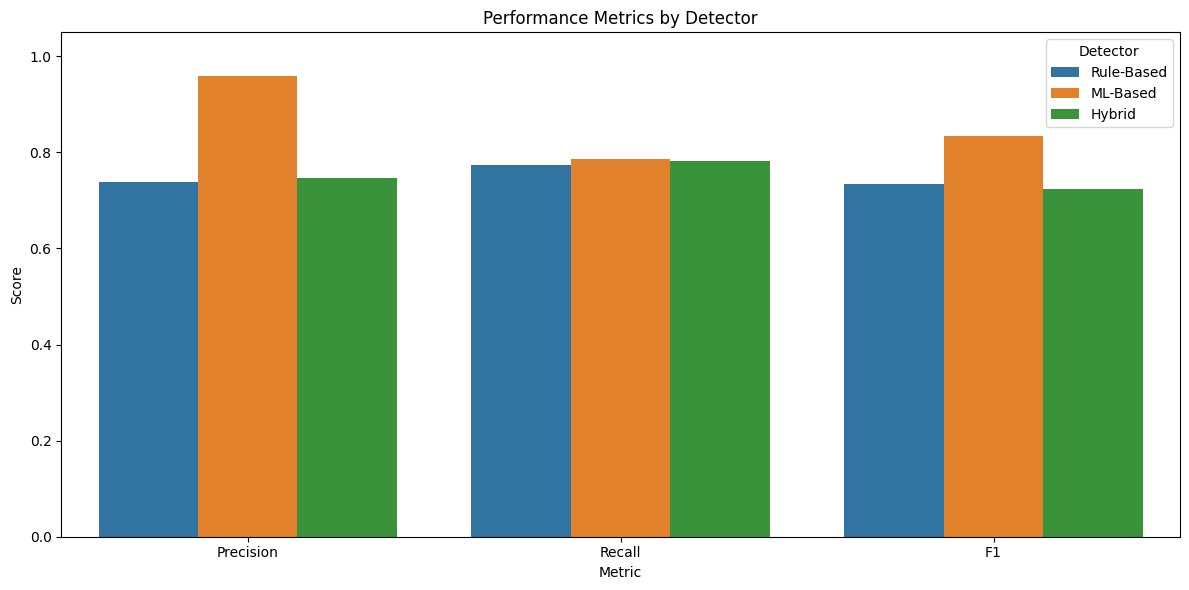

In [10]:
# Bar chart comparison across detectors
from sklearn.metrics import precision_recall_fscore_support, accuracy_score

bar_results = []

for name, (path, y_col, p_col) in files.items():
    if os.path.exists(path):
        df = pd.read_csv(path)
        y_true = df[y_col]
        y_pred = df[p_col]

        precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average=None, zero_division=0)
        acc = accuracy_score(y_true, y_pred)

        bar_results.append({
            "Detector": name,
            "Class": "Normal",
            "Precision": precision[0],
            "Recall": recall[0],
            "F1": f1[0]
        })
        bar_results.append({
            "Detector": name,
            "Class": "Attacker",
            "Precision": precision[1],
            "Recall": recall[1],
            "F1": f1[1]
        })
        bar_results.append({
            "Detector": name,
            "Class": "Overall",
            "Precision": acc,
            "Recall": acc,
            "F1": acc
        })

bar_df = pd.DataFrame(bar_results)
melted_bar = bar_df.melt(id_vars=["Detector", "Class"], var_name="Metric", value_name="Score")

plt.figure(figsize=(12, 6))
sns.barplot(data=melted_bar, x="Metric", y="Score", hue="Detector", errorbar=None)
plt.title("Performance Metrics by Detector")
plt.ylim(0, 1.05)
plt.tight_layout()
plt.show()
